
# Dynamic SIMM for MVA and CVA

OTC derivatives business is typically collateralized with both Variation Margin (VM) and Initial Margin (IM) nowadays. This means over-collateralization in many scenarios, though extreme scenarios and market stress can lead to significant exposure and losses. More so, wrong-way risk can even cause significant expected losses, despite of VM and IM. 

For a given netting set, IM is both called from the counterparty and posted to the counterparty. These IM amounts might differ, and they are not netted. 

IM **called from** the counterparty suppresses credit exposure and CVA (in normal markets, without wrong-way risk); for credit exposure and CVA modelling we need to evaluate IM path-wise to offset the exposure after VM correctly on each path, before we compute the residual exposure after VM and IM.
  
IM **posted to** the counterparty causes additional funding cost that are priced as Margin Value Adjustment (MVA); its key ingredient is the Expected (Discounted) Future IM through the life of the portfolio.
 
To compute IM, the Dynamic SIMM method in ORE embeds full ISDA SIMM calculation into ORE's American Monte Carlo simulation framework with fast pathwise sensitivity calculation using AAD. 

The examples below consider a netting set containing a single Bermudan Swaption (in EUR, cash settled, maturity 10Y, annual exercise from 5Y onwards). The market data used here is close to realistic but somewhat stressed (compared to the reference market in February 2025) with flat normal Swaption volatility at 150bp.

Prerequisites:
- Python 3
- ORE Python module: run "**pip install open-source-risk-engine**" to get the latest version
- Python modules: matplotlib, pandas, numpy, statistics, lxml

### Import modules

In [1]:
from ORE import *

import sys, time, math
sys.path.append('..')
import utilities
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import pandas as pd
import numpy as np
import statistics as stats
import lxml.etree as etree

# Example 1: Standard AMC, Variation Margin

This example assumes Variation Margin only, no Initial Margin yet. We apply the usual AMC framework with a close-out grid for VM modelling and 10k samples. We will extend this example further below to include IM.

Expected runtime on a MacBook Pro, Apple M2 Max, single core: ~22sec

In [2]:
params_vm = Parameters()
params_vm.fromFile("Input/Dim2/ore_vm.xml")
ore_vm = OREApp(params_vm)
ore_vm.run()
utilities.checkErrorsAndRunTime(ore_vm)
utilities.writeList(ore_vm.getReportNames())

Run time: 21.88 sec
Errors: 0

- additional_results
- colva_nettingset_CPTY_A
- cva_sensitivity_nettingset_CPTY_A
- dividends
- exposure_nettingset_CPTY_A
- exposure_trade_BermudanSwaptionCash
- fixings
- marketdata
- npv
- pricingstats
- runtimes
- todaysmarketcalibration
- xva


### Plot Exposure before and after VM

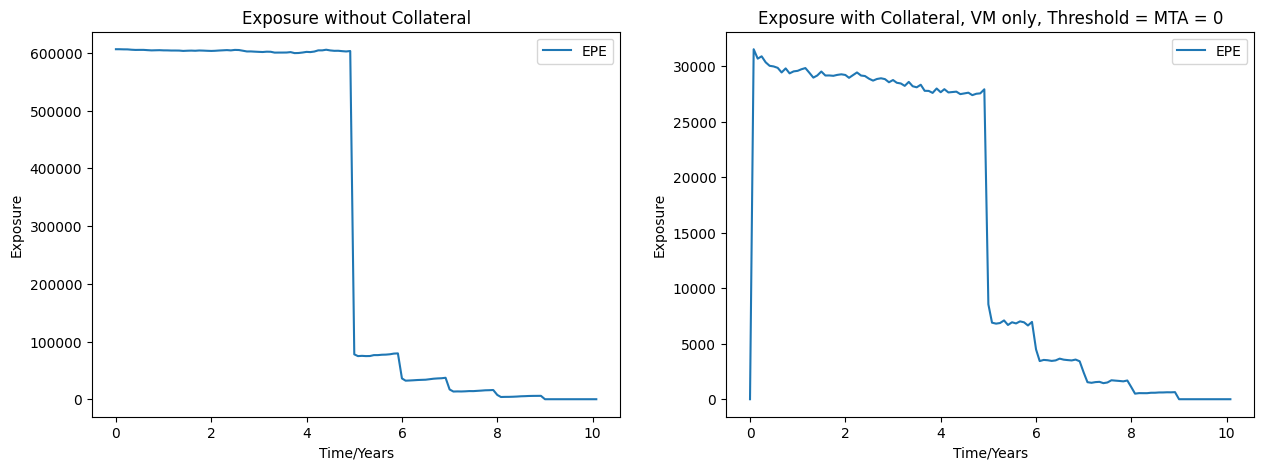

In [3]:
# get the uncollateralized exposure from the trade exposure report
report_none = ore_vm.getReport("exposure_trade_BermudanSwaptionCash")
# get the collateralized exposure from the netting set report
report_vm = ore_vm.getReport("exposure_nettingset_CPTY_A")

time = report_vm.dataAsReal(2)
epe_none = report_none.dataAsReal(3)
epe_vm = report_vm.dataAsReal(3)

fig = plt.figure(figsize=(15, 5))
gs = GridSpec(nrows=1, ncols=2)
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])

ax0.plot(time, epe_none, label='EPE')
ax0.set(xlabel='Time/Years')
ax0.set(ylabel='Exposure')
ax0.set_title('Exposure without Collateral')
ax0.legend()

ax1.plot(time, epe_vm, label='EPE')
ax1.set(xlabel='Time/Years')
ax1.set(ylabel='Exposure')
ax1.set_title('Exposure with Collateral, VM only, Threshold = MTA = 0')
ax1.legend()

plt.show()

Note:
- The exposure on the right is just due to the Margin Period of Risk
- Ballpark factor 20 reduced compared to the uncollateralized exposure.

# Example 2: Add Initial Margin

We now switch to American Monte Carlo on the Computation Graph (AMC/CG) in order to compute dynamic AAD sensitivities and Dynamic SIMM and run again. Check the essential differences in our setups, ore_im.xml vs ore_vm.xml:

| Parameter | ore_im.xml | ore_vm.xml |
| --- | --- | --- |
| simulation/amcCg | CubeGeneration | Disabled |
| simulation/xvaCgDynamicIM | true | false |
| xva/csaFile | netting_im.xml | netting_vm.xml |
| xva/dim | true | false |
| xva/mva | true | false |

and note that the netting_im.xml file has the ApplyInitialMargin flag set to true.

Expected runtime on a MacBook Pro, Apple M2 Max, single core: ~44sec (i.e. doubling the run time of Example 1)

In [4]:
params_im = Parameters()
params_im.fromFile("Input/Dim2/ore_im.xml")
ore_im = OREApp(params_im)
ore_im.run()
utilities.checkErrorsAndRunTime(ore_im)
utilities.writeList(ore_im.getReportNames())

Run time: 44.71 sec
Errors: 0

- additional_results
- colva_nettingset_CPTY_A
- cva_sensitivity_nettingset_CPTY_A
- dim_cube
- dim_distribution
- dim_evolution
- dim_regression_0
- dividends
- exposure_nettingset_CPTY_A
- exposure_trade_BermudanSwaptionCash
- fixings
- marketdata
- npv
- pricingstats
- runtimes
- todaysmarketcalibration
- xva
- xvacg-regression


### Plot Expected IM and Exposure after VM+IM

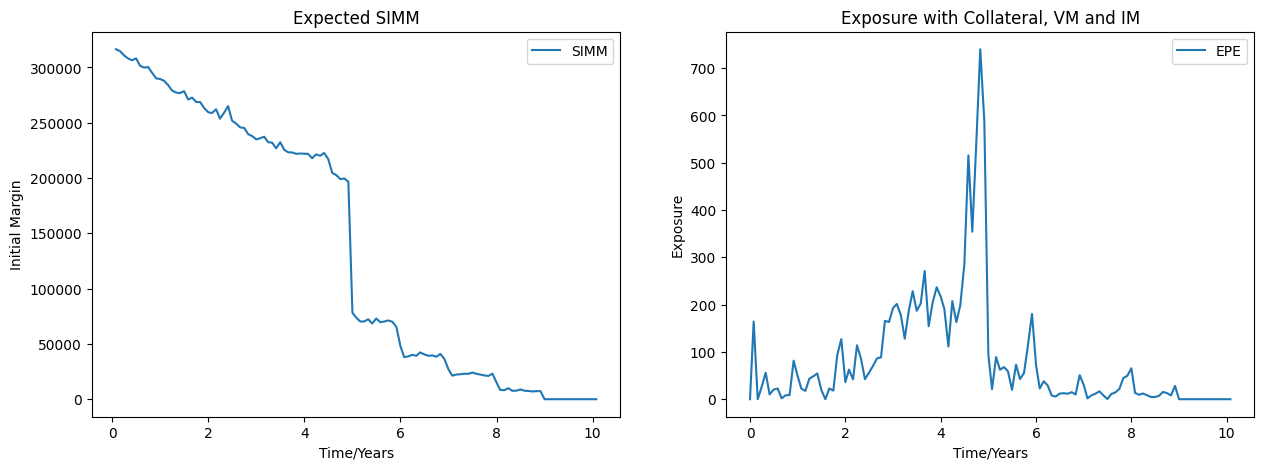

In [5]:
def plot_simm_epe(dimReport, exposureReport):
    time_dim = dimReport.dataAsReal(8)
    dim = dimReport.dataAsReal(4)
    time_epe = exposureReport.dataAsReal(2)
    epe = exposureReport.dataAsReal(3)

    fig = plt.figure(figsize=(15, 5))
    gs = GridSpec(nrows=1, ncols=2)
    ax0 = fig.add_subplot(gs[0, 0])
    ax1 = fig.add_subplot(gs[0, 1])

    ax0.plot(time_dim, dim, label='SIMM')
    ax0.set(xlabel='Time/Years')
    ax0.set(ylabel='Initial Margin')
    ax0.set_title('Expected SIMM')
    ax0.legend()

    ax1.plot(time_epe, epe, label='EPE')
    ax1.set(xlabel='Time/Years')
    ax1.set(ylabel='Exposure')
    ax1.set_title('Exposure with Collateral, VM and IM')
    ax1.legend()

    plt.show()

# get the Dynamic Initial Margin evolution report
report_dim = ore_im.getReport("dim_evolution")
# get the exposure from the netting set report
report_exp = ore_im.getReport("exposure_nettingset_CPTY_A")
# plot them
plot_simm_epe(report_dim, report_exp)


### Note

- Expected SIMM far exceeds the expected exposure after VM here, it feeds directly into the MVA calculaton below
- Residual exposure after VM and IM is small and suffers from poor statistics - small number of MC samples contribute to EPE, even though we are using a stressed market with elevated Swaption volatility (see Example 3 below)

### MVA

Expected Discounted SIMM feeds directly into the calculation of MVA, written to the xva report (output file Output/Dim2/AmcCg/xva.csv), 
\begin{align}
\mathit{MVA} &= \sum_{i=1}^n (f_b - s_I)\times \delta_i \times S_{ours}(t_i)\times S_{theirs}(t_i) \times \mathbb{E}^N\left[
\frac{\mathit{DIM}(t_i)}{N(t_i)}\right].  
\end{align}
for an arbitrary spread $f_b-s_I = 0.01$, "our" survival probability $S_{ours}(t)=1$ and counterparty survival probability $S_{theirs}(t)=\exp(-h\,t)$ with flat hazard rate $h=0.01$ in this Example 2.

### Choice of regression method and the Python integration layer

For the evaluation of conditional expectations of sensitivities under AMC we have used simple polynomial regression of order 4 here. We have shown here (https://ssrn.com/abstract=5517378) that **local regression** can be more appropriate in case of option products. 

Local regression methods can be applied in ORE with the help of ORE's Python integration layer (not to be confused with the ORE Python module) that offers regression methods such as MARS (in the py-earth2 Python package) and various others (contained in the scikit-learn Python package). See the ORE user guide for instructions on how to build ORE with this integration and how to parametrise ORE to use it. We demonstrate this use case below in Example 4.

# Example 3: Repeat Example 2 with 100k Samples

Expected runtime on a MacBook Pro, Apple M2 Max, single core: ~330sec (i.e. factor 15 compared to Example 1)

In [6]:
params_im_100k = Parameters()
params_im_100k.fromFile("Input/Dim2/ore_im_100k.xml")
ore_im_100k = OREApp(params_im_100k)
ore_im_100k.run()
utilities.checkErrorsAndRunTime(ore_im_100k)
utilities.writeList(ore_im_100k.getReportNames())

Run time: 339.18 sec
Errors: 0

- additional_results
- colva_nettingset_CPTY_A
- cva_sensitivity_nettingset_CPTY_A
- dim_cube
- dim_distribution
- dim_evolution
- dim_regression_0
- dividends
- exposure_nettingset_CPTY_A
- exposure_trade_BermudanSwaptionCash
- fixings
- marketdata
- npv
- pricingstats
- runtimes
- todaysmarketcalibration
- xva


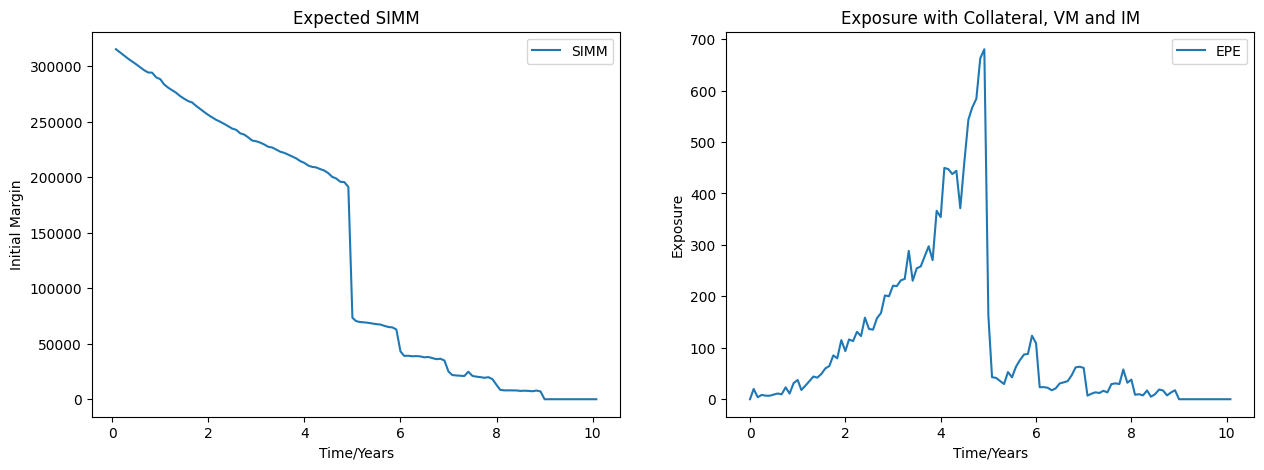

In [7]:
report_dim_100k = ore_im_100k.getReport("dim_evolution")
report_exp_100k = ore_im_100k.getReport("exposure_nettingset_CPTY_A")
plot_simm_epe(report_dim_100k, report_exp_100k )

As expected, less noisy than above but confirming the IM and Exposure evolutions obtained with 10k samples.

# Example 4: Repeat Example 2 with MARS regression

To illustrate the sensitivity of results to the choice of the regression method, we apply MARS regression as discussed in https://ssrn.com/abstract=5517378, because it was shown to perform better than polynomial regression for European options approaching expiry.

This is achieved with a small modification of the input file ore_im.xml, i.e. 
- flip the relevant flag to true, so that we utilise the Python integration layer, here to apply MARS regression instead of polynomial regression
- and redirect output into a different folder

| Parameter | Original | Amended |
| --- | --- | --- |
| Analytics/Analytic[@type='simulation']/Parameter[@name='xvaCgUsePythonIntegration'] | false | true |
| Setup/Parameter[@name='outputPath'] | Output/Dim2/AmcCg | Output/Dim2/AmcCgPy |

We could have provided an additional ore XML input file for that purpose with these two differences compared to ore_im.xml. But since it is straight forward to parse and edit ore_im.xml, we have chosen this approach here.

In [8]:
def updateOreXml(oreFile, folder, flag):
    doc = etree.parse(oreFile)
    nodes1 = doc.xpath("//ORE/Setup/Parameter[@name='outputPath']")
    originalFolder = nodes1[0].text
    nodes1[0].text = folder
    nodes2 = doc.xpath("//ORE/Analytics/Analytic[@type='simulation']/Parameter[@name='xvaCgUsePythonIntegration']")
    originalFlag = nodes2[0].text
    nodes2[0].text = flag
    doc.write(oreFile)
    print(oreFile, "updated:", originalFolder, "->", folder)
    print(oreFile, "updated:", originalFlag, "->", flag)
    return originalFolder, originalFlag
    
oreFile = "Input/Dim2/ore_im.xml"
newFolder = "Output/Dim2/AmcCgPy"
newFlag = "true"

# update now, and keep original values in mind for restoring them below
originalFolder, originalFlag = updateOreXml(oreFile, newFolder, newFlag)


Input/Dim2/ore_im.xml updated: Output/Dim2/AmcCg -> Output/Dim2/AmcCgPy
Input/Dim2/ore_im.xml updated: false -> true


### Now re-run Example 2

The change above means that all regression calculations, for NPV and sensitivities, are replaced with MARS regressions.

Expected runtime on a MacBook Pro, Apple M2 Max, single core: ~150sec (compare to 40sec with polynomial regression in Example 2)

In [9]:
params_impy = Parameters()
params_impy.fromFile("Input/Dim2/ore_im.xml")
ore_impy = OREApp(params_impy)
ore_impy.run()
utilities.checkErrorsAndRunTime(ore_impy)
utilities.writeList(ore_impy.getReportNames())

Run time: 155.20 sec
Errors: 0

- additional_results
- colva_nettingset_CPTY_A
- cva_sensitivity_nettingset_CPTY_A
- dim_cube
- dim_distribution
- dim_evolution
- dim_regression_0
- dividends
- exposure_nettingset_CPTY_A
- exposure_trade_BermudanSwaptionCash
- fixings
- marketdata
- npv
- pricingstats
- runtimes
- todaysmarketcalibration
- xva
- xvacg-regression


Restore the original parameters in ore_im.xml

In [10]:
a,b = updateOreXml(oreFile, originalFolder, originalFlag)

Input/Dim2/ore_im.xml updated: Output/Dim2/AmcCgPy -> Output/Dim2/AmcCg
Input/Dim2/ore_im.xml updated: true -> false


### Plot a few SIMM paths 

This illustrates types of discrepancy, including noticeably lower SIMM with MARS (lower left) and deviating exercise decisions (lower right), while some paths match closely (upper left and right). The data is taken from the respective "dim_cube.csv" files.

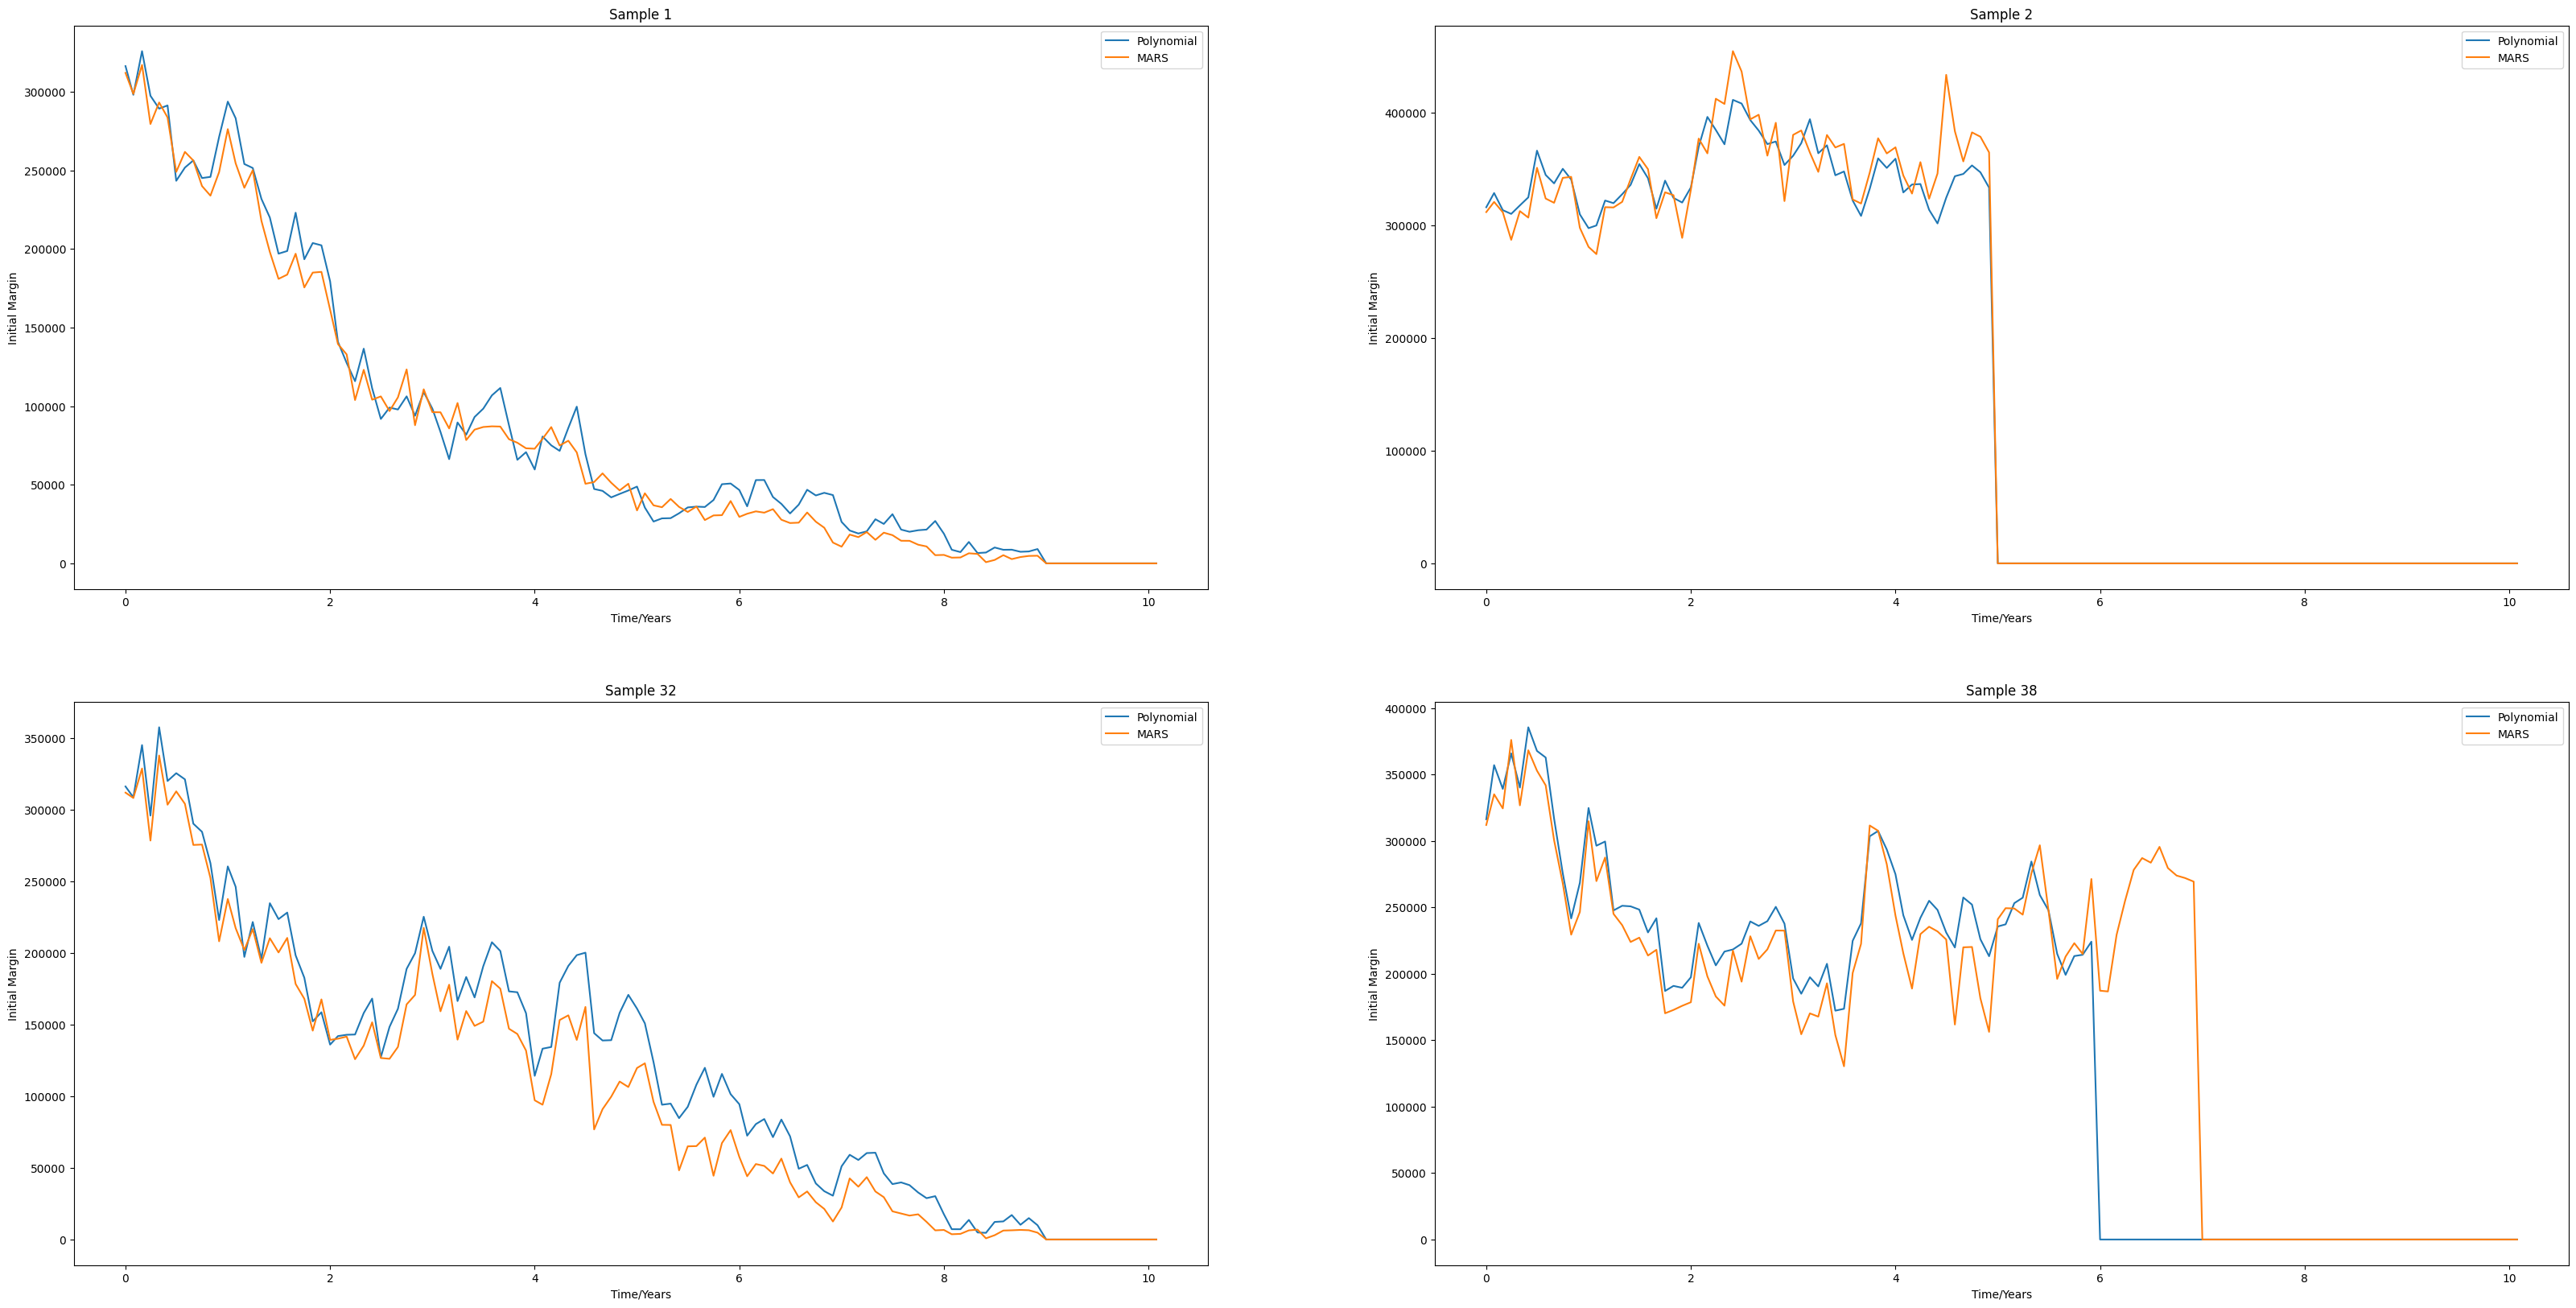

In [11]:
cubeFilePoly = "Output/Dim2/AmcCg/dim_cube.csv"
cubeFileMars = "Output/Dim2/AmcCgPy/dim_cube.csv"

def simmEvolution(simmCubeFile, sample, depth): 
    data = pd.read_csv(simmCubeFile)
    df = data[data["Sample"] == sample]
    df = df[df["Depth"] == depth]
    return df

def plotPathwiseComparison(ax, sample, depth):
    dfPoly = simmEvolution(cubeFilePoly, sample, depth)
    dfMars = simmEvolution(cubeFileMars, sample, depth)
    time = dfPoly["Time"]
    dimPoly = dfPoly["InitialMargin"]
    dimMars = dfMars["InitialMargin"]
    ax.plot(time, dimPoly, label='Polynomial')
    ax.plot(time, dimMars, label='MARS')
    ax.set(xlabel='Time/Years')
    ax.set(ylabel='Initial Margin')
    ax.set_title('Sample ' + str(sample))
    ax.legend()

fig = plt.figure(figsize=(40, 20))
gs = GridSpec(nrows=2, ncols=2)
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])

# 13 21 26 27 32 33 38 39 40 45 48 56
plotPathwiseComparison(ax0, 1, 0)
plotPathwiseComparison(ax1, 2, 0)
plotPathwiseComparison(ax2, 32, 0)
plotPathwiseComparison(ax3, 38, 0)

plt.show()

### Compare SIMM distributions 

For a broader comparison across all paths, we look at SIMM distributions below. 

Utilising the same dim_cube.csv output files, we focus on a few future dates
- time 3 corresponding to date 2028-02-10
- time 4 corresponding to date 2029-02-10, i.e. one year before the first call
- time 5.5 corresponding to date 2030-08-10, i.e. between first can second call

We plot the SIMM distributions associated with the two regression methods into a single diagram.

Date:        2028-02-10
Path length:   10000    10000
Minimum:       11664    44026
Maximum:     1310453  3218592
StdDev:       138719   153888


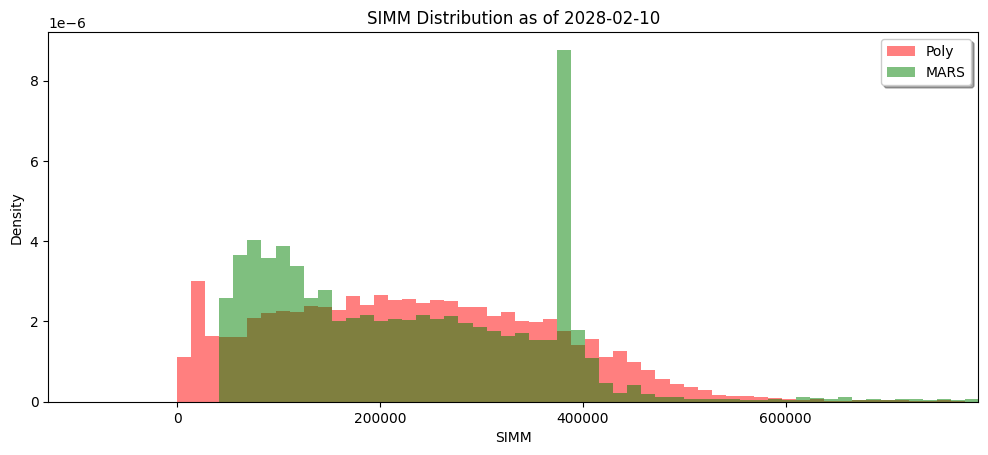

Date:        2029-02-10
Path length:   10000    10000
Minimum:       17043    42087
Maximum:     1707090  2563800
StdDev:       162310   177918


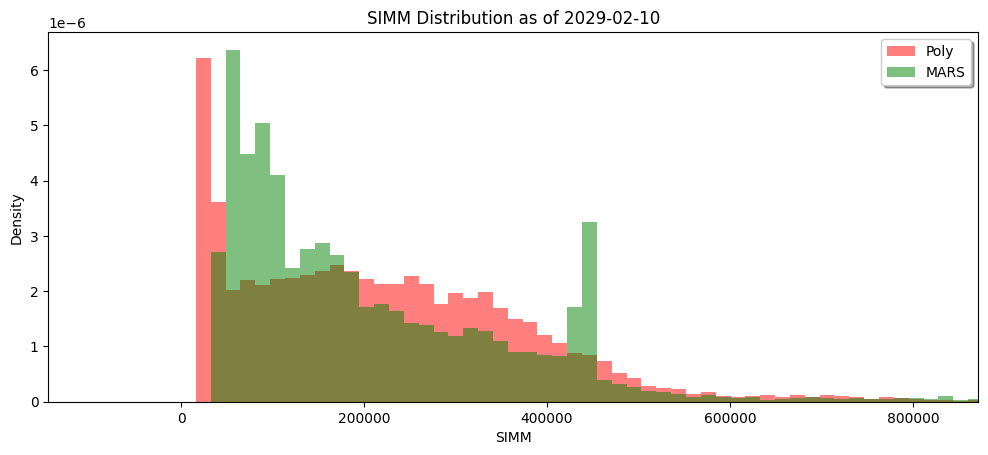

Date:        2030-08-10
Path length:   10000    10000
Minimum:           0        0
Maximum:      689804   369812
StdDev:        75858    75502


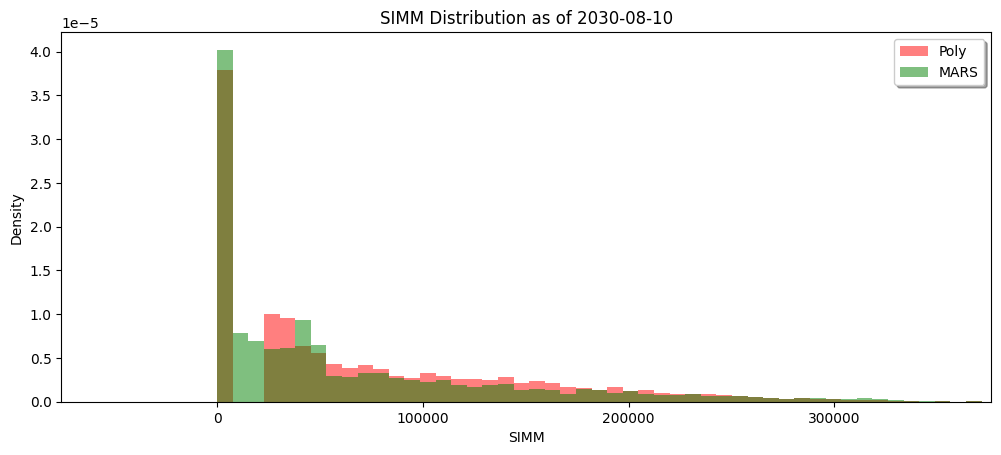

In [12]:
cubeFilePoly = "Output/Dim2/AmcCg/dim_cube.csv"
cubeFileMars = "Output/Dim2/AmcCgPy/dim_cube.csv"

dfPoly = pd.read_csv(cubeFilePoly)
dfMars = pd.read_csv(cubeFileMars)

asofDates = dfPoly["AsOfDate"].unique()
#print("dates:", asofDates)

def getSimmData(df, date, depth):
    df2 = df[ df["AsOfDate"] == date ]
    df3 = df2[ df2["Depth"] == depth ]
    x = df3["InitialMargin"]
    return x

def computeBins(min_val, max_val, desired_bin_size):
    min_boundary = -1.0 * (min_val % desired_bin_size - min_val)
    max_boundary = max_val - max_val % desired_bin_size + desired_bin_size
    n_bins = int((max_boundary - min_boundary) / desired_bin_size) + 1
    bins = np.linspace(min_boundary, max_boundary, n_bins)
    return bins

def plotDistributionComparison(date):
    fig = plt.figure(figsize=plt.figaspect(0.4))
    x_1 = getSimmData(dfPoly, date, 0) 
    x_2 = getSimmData(dfMars, date, 0)
    stdbins = 10 # bins per std dev in x_1
    # force common bins using benchmark 2 as reference
    mini = min(x_1)
    maxi = max(x_1)
    std = stats.stdev(x_1)
    print("Date:        %s" % date)
    print("Path length: %7d  %7d" % (len(x_1), len(x_2)))
    print("Minimum:     %7.0f  %7.0f" % (mini, min(x_2)))
    print("Maximum:     %7.0f  %7.0f" % (maxi, max(x_2)))
    print("StdDev:      %7.0f  %7.0f" % (std, stats.stdev(x_2)))
    width = std / stdbins
    upperLimit = stats.mean(x_1) + 4 * std # maxi + std
    lowerLimit = mini - std
    bins = computeBins(mini, maxi, width)
    plt.hist(x_1, density=True, bins=bins, color="red", alpha=0.5, label="Poly")
    plt.hist(x_2, density=True, bins=bins,color="green", alpha=0.5, label="MARS")
    plt.xlim(xmin=lowerLimit, xmax=upperLimit)
    plt.legend(frameon=True, shadow=True)
    plt.xlabel("SIMM")
    plt.ylabel("Density")
    plt.title("SIMM Distribution as of " + str(date))
    plt.show()

plotDistributionComparison("2028-02-10")
plotDistributionComparison("2029-02-10")
plotDistributionComparison("2030-08-10")
